# ML - IE406 Project

Group Details

**Group - 21**

1. Kushagra Pathak - 201801005
2. Harsh Modi - 201801029
3. Parth Naghera-201801176
4. Harsh Patel - 201801411
5. Vatsal Agrawal-201801053





In [ ]:
!pip install hmmlearn

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import numpy as np
from matplotlib.text import Annotation
from sklearn.preprocessing import scale
import matplotlib.image as mplib 
import pandas as pd
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from statsmodels.graphics.gofplots import qqplot
import sympy as sp
import warnings
import math
import random
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA
import scipy.io 
import cv2 
import time
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from hmmlearn import hmm
import plotly.express as px


warnings.filterwarnings('ignore')

plt.style.use('seaborn')

In [ ]:
NUM_TEST = 100  # number of samples in test set
K = 50          # lag parameters
NUM_ITERS=10000 # number of iterations

labels = ['Confirmed','Deaths','Recovered']
like_vector = np.empty([0,1])
AIC_array = np.empty([0,1])
BIC_array = np.empty([0,1])

STATES = range(2,15) # number of states in HMM (possible)

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IE406_ML_datasets_folder/covid_19_combined.csv')

In [ ]:
data.tail()

,ObservationDate,Province/State,Country,Lat,Long,Confirmed,Deaths,Recovered
171971,11/11/21,NaN,Zimbabwe,-19.015438,29.154857,133329,4694,0
171972,11/12/21,NaN,Zimbabwe,-19.015438,29.154857,133329,4694,0
171973,11/13/21,NaN,Zimbabwe,-19.015438,29.154857,133393,4696,0
171974,11/14/21,NaN,Zimbabwe,-19.015438,29.154857,133428,4696,0
171975,11/15/21,NaN,Zimbabwe,-19.015438,29.154857,133438,4697,0


In [ ]:
# # India specific data
# dataIndia = data.loc[data['Country'] == 'India'].groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()
# dataIndia.index = pd.to_datetime(dataIndia.iloc[:,0].index)
# dataIndia = dataIndia.sort_index()


In [ ]:
def calc_mape(predicted_data, true_data):
  temp_ = np.full(true_data.shape, 0.000000000001)
  return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), np.maximum(temp_,true_data)), 0), true_data.shape[0])

In [ ]:
def HMM_fun(data):
  dataset = np.array(data)
  pred_data = np.empty([0,dataset.shape[1]])
  like_vector = np.empty([0,1])
  AIC_array = np.empty([0,1])
  BIC_array = np.empty([0,1])
  for states in STATES:

      # parameters count
      params_cnt = states**2 + states
      dirichlet_params_states = np.random.randint(1,50,states)

      # instantiate the HMM model
      model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
      
      # train the model
      model.fit(dataset[NUM_TEST:,:])
      
      if model.monitor_.iter == NUM_ITERS:
          print('Increase number of iterations')
          sys.exit(1)

      like_vector = np.vstack((like_vector, model.score(dataset)))
      AIC_array = np.vstack((AIC_array, -2 * model.score(dataset) + 2 * params_cnt))
      BIC_array = np.vstack((BIC_array, -2 * model.score(dataset) +  params_cnt * np.log(dataset.shape[0])))
    
  optimal_cnt = np.argmin(BIC_array) + 2 # optimal number of states in HMM
  print('Optimum number of states are {}'.format(optimal_cnt))

  for index in reversed(range(NUM_TEST)):
      
      # train-test split
      train_data = dataset[index+1:,:]
      test_data = dataset[index,:]; 
      
      # number of training samples
      exmple_cnt = train_data.shape[0]
      
      if index == NUM_TEST - 1:
          model = hmm.GaussianHMM(n_components=optimal_cnt, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
      else:
          
          # if not the first iteration from last, then use prior probabilities 
          model = hmm.GaussianHMM(n_components=optimal_cnt, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
          model.transmat_ = transition_prob_matrix  # transition probability matrix
          model.startprob_ = start_prob_matrix # starting probability matrix
          model.means_ = prior_means # means in previous iteration
          model.covars_ = prior_covars # covariances in previous iteration

      model.fit(np.flipud(train_data))

      transition_prob_matrix = model.transmat_
      start_prob_matrix = model.startprob_
      prior_means = model.means_
      prior_covars = model.covars_

      # if model.monitor_.iter == NUM_ITERS:
      #     print('Increase number of iterations')
      #     sys.exit(1)
      
      cnt = 1;
      like_prev = []
      like_present = model.score(np.flipud(train_data[0:K - 1, :]))
      while cnt < exmple_cnt / K - 1:
          like_prev = np.append(like_prev, model.score(np.flipud(train_data[cnt:cnt + K - 1, :])))
          cnt = cnt + 1
      differential_like_index = np.argmin(np.absolute(like_prev - like_present))
      delta_predicted = train_data[differential_like_index,:] - train_data[differential_like_index + 1,:]
      pred_data = np.vstack((pred_data, dataset[index + 1,:] + delta_predicted))
  
  return pred_data


In [ ]:
dataWorld = data.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()
dataWorld.index = pd.to_datetime(dataWorld.iloc[:,0].index)
dataWorld = dataWorld.sort_index()
# dataWorld = dataWorld.loc[dataWorld.index <= pd.to_datetime('2021-06-30')]
dataWorld

,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-01-22,551,17,30
2020-01-23,649,17,32
2020-01-24,930,25,39
2020-01-25,1394,41,42
2020-01-26,2021,54,56
...,...,...,...
2021-11-11,249993055,5046299,0
2021-11-12,250574235,5054911,0
2021-11-13,251001150,5061727,0


In [ ]:
data = dataWorld # dataIndia or dataWorld
output = HMM_fun(data) # prediction
pd.DataFrame(np.flipud(output))

Optimum number of states are 4


,0,1,2
0,368.0,9.0,25.0
1,466.0,9.0,36.0
2,767.0,28.0,28.0
3,1262.0,28.0,47.0
4,185.0,31.0,22.0
...,...,...,...
95,2919909.0,210932.0,821111.0
96,2991875.0,217505.0,844616.0
97,3061312.0,225036.0,862569.0
98,3138550.0,231517.0,953776.0


In [ ]:
mape = 100*calc_mape(np.flipud(output), (dataWorld.iloc[range(NUM_TEST),:]))
mape

Confirmed    4.870116
Deaths       4.892100
Recovered    5.619869
dtype: float64

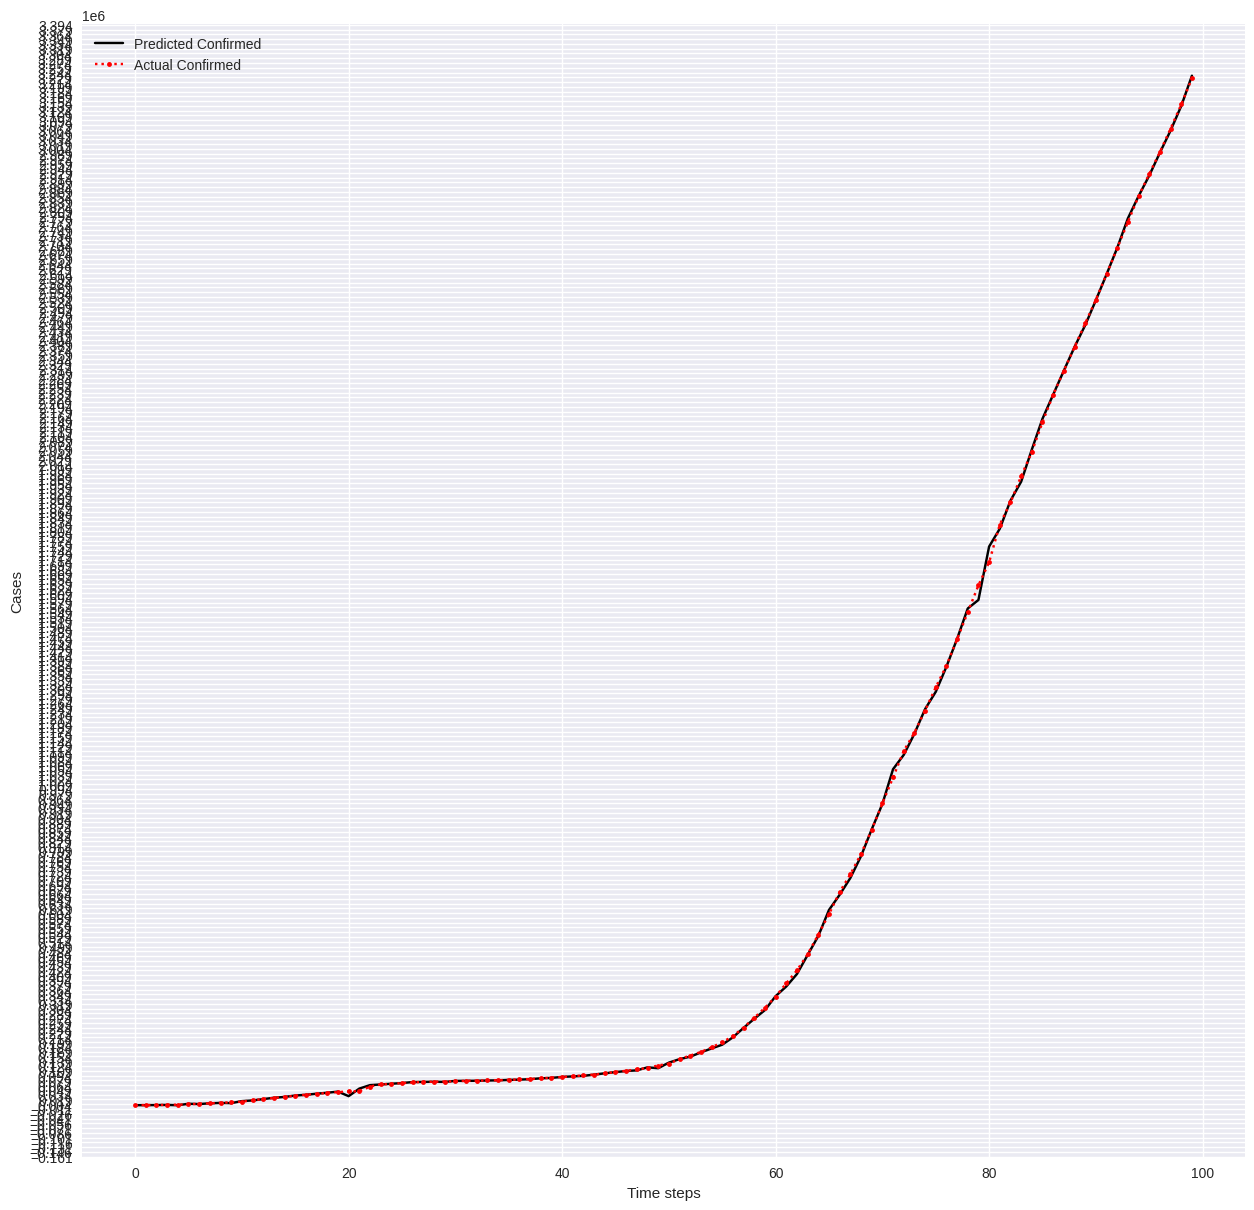

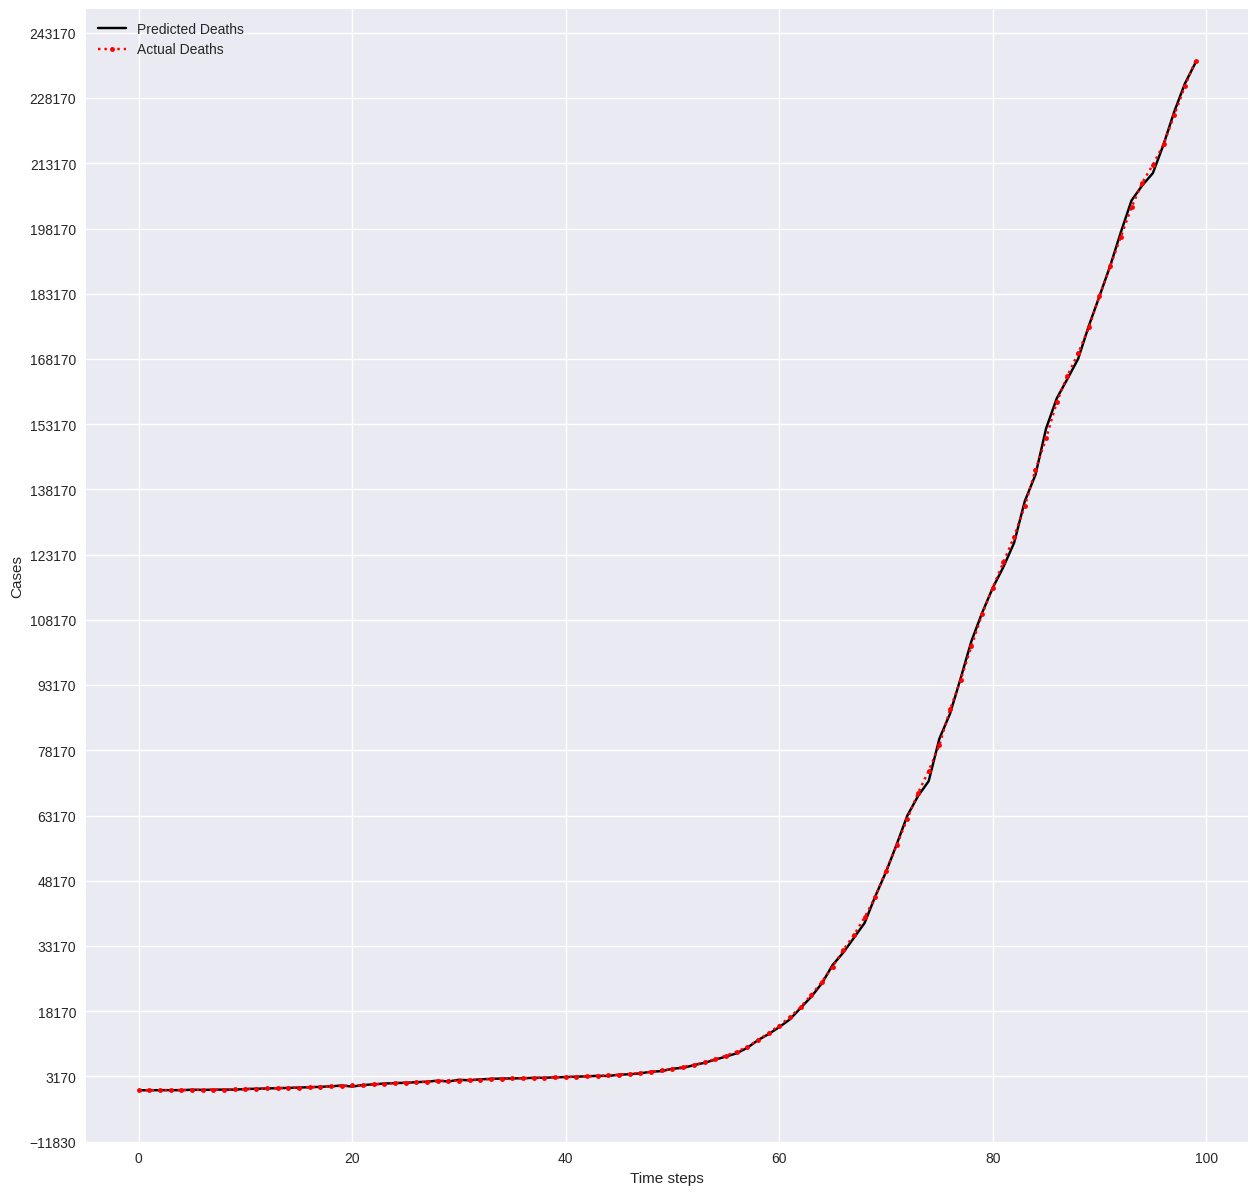

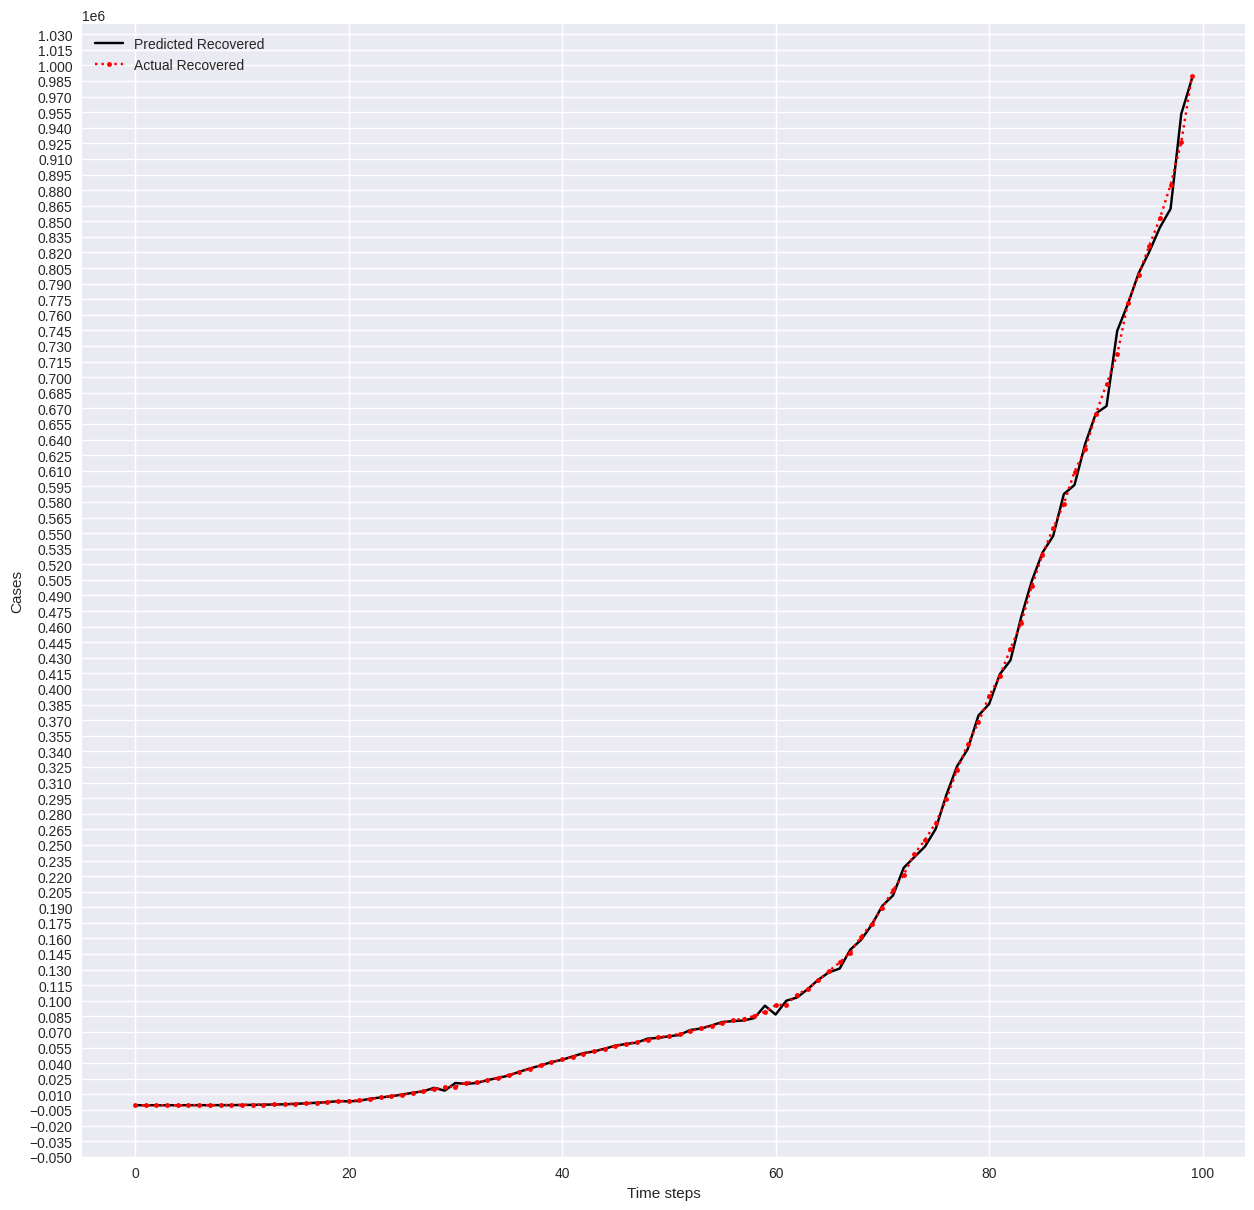

In [ ]:
for i in range(3):
  plt.figure(figsize=(15,15), dpi=100)
  plt.xlabel('Time steps')
  plt.ylabel('Cases')
  plt.plot(range(NUM_TEST), np.flipud(output[:,i]),'k-', label = 'Predicted '+labels[i]);
  plt.plot(range(NUM_TEST), data.iloc[range(NUM_TEST),i],'r', label = 'Actual '+labels[i], marker='.', linestyle=':')

  ymin, ymax = plt.ylim()
  plt.yticks(np.arange(ymin, ymax+1, 1.5*10000))
  plt.legend()
  plt.savefig(f'World_cases_{labels[i]}.png', bbox_inches='tight')

plt.grid(True)
plt.show()